Collect & CLean Stock Data

In [18]:
# %% [markdown]
# # 1. 环境配置与依赖导入
# %%
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# 代理配置（按需调整，无代理可注释）
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

# 绘图风格设置
plt.style.use('fivethirtyeight')

In [19]:
df = pd.read_csv('my_portfolio_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.drop('Unnamed: 0',axis=1,inplace=True)

In [20]:
# import pandas as pd
# import yfinance as yf
# import os

# # 1. 定义文件名
# DATA_FILE = "my_portfolio_data.csv"
# TICKERS = ["AAPL", "MSFT", "TSLA", "GOOG", "META"] # 你想研究的股票

# def get_stock_data():
#     # === 检查本地是否有缓存 ===
#     if os.path.exists(DATA_FILE):
#         print("✅ 发现本地数据，正在读取...")
#         # index_col=[0,1] 是因为 yfinance 多股票下载通常是双层索引 (Date, Ticker)
#         # 如果你下载下来的格式只有 Date，那就改成 index_col=0
#         df = pd.read_csv(DATA_FILE, index_col=0, parse_dates=True)
#         return df
    
#     # === 本地没有，联网下载 ===
#     print("🌐 本地无数据，正在从 Yahoo 下载...")
    
#     # 下载多只股票数据
#     # group_by='ticker' 会让数据结构更适合后续处理
#     df = yf.download(TICKERS, period="2y", group_by='ticker')
    
#     # === 数据变形 (关键一步) ===
#     # yfinance 下载多只股票时，格式会很乱 (MultiIndex)。
#     # 我们把它变成长格式 (Long Format)，方便 XGBoost 处理。
#     # 这一步如果不做，后面特征工程会死人。
#     df_stack = df.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index()
    
#     # === 保存到本地 ===
#     df_stack.to_csv(DATA_FILE)
#     print(f"💾 数据已保存到 {DATA_FILE}")
    
#     return df_stack

# # --- 执行 ---
# df = get_stock_data()
# print(df.head())

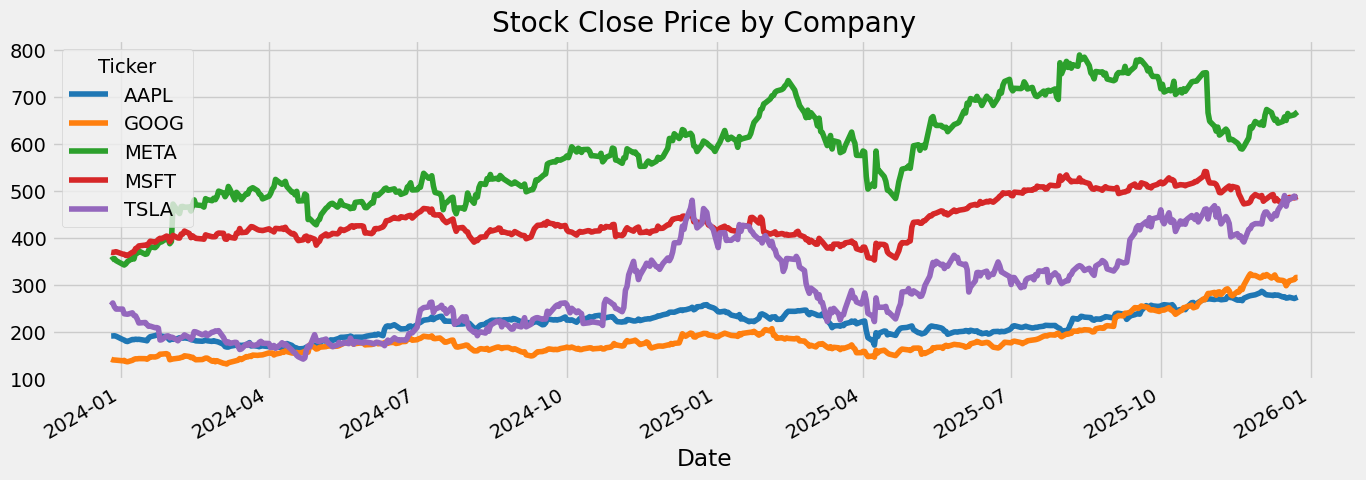

In [21]:
color_pal = sns.color_palette('tab10', 5)
# 按Ticker分组，遍历绘图
for (ticker, group), color in zip(df.groupby('Ticker'), color_pal):
    group.plot(
        y='Close', 
        label=ticker,  # 图例显示公司代码
        color=color,   # 分配专属颜色
        figsize=(15, 5),
        ax=plt.gca()   # 绘制在同一张图上
    )
# 设置标题和图例
plt.title('Stock Close Price by Company')
plt.legend(title='Ticker')
plt.show()

In [ ]:
# # ===================== 最终最终版：解决所有报错 + 精准合并 =====================
# import yfinance as yf
# import pandas as pd
# import os
# from datetime import datetime, timedelta
# import numpy as np

# # 【核心配置】
# STOCK_DATA_FILE = "my_portfolio_data.csv"  # 你的个股数据文件
# MERGED_OUTPUT_FILE = "final_merged_data.csv"  # 最终合并结果
# PROXY = "http://127.0.0.1:7890"

# # 代理设置
# os.environ['HTTP_PROXY'] = PROXY
# os.environ['HTTPS_PROXY'] = PROXY

# # -------------------- 第一步：处理个股数据（最稳妥方式） --------------------
# def process_stock_data():
#     """读取个股数据，确保Date为字符串，无空值"""
#     # 读取数据
#     stock_df = pd.read_csv(STOCK_DATA_FILE)
    
#     # 1. 清理空值和无效日期
#     stock_df = stock_df.dropna(subset=['Date'])
#     stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')
#     stock_df = stock_df.dropna(subset=['Date'])
    
#     # 2. 转为字符串格式（YYYY-MM-DD）
#     stock_df['Date'] = stock_df['Date'].dt.strftime("%Y-%m-%d")
    
#     # 3. 强制扁平化，重置索引
#     stock_df = stock_df.reset_index(drop=True)
    
#     print(f"✅ 个股数据处理完成")
#     print(f"   - 记录数：{len(stock_df)}")
#     print(f"   - 时间范围：{stock_df['Date'].min()} ~ {stock_df['Date'].max()}")
#     print(f"   - 包含2023-12-26：{'✅' if '2023-12-26' in stock_df['Date'].values else '❌'}")
#     return stock_df

# # -------------------- 第二步：下载大盘数据（逐行构建，避免维度问题） --------------------
# def download_macro_data(stock_dates):
#     """下载大盘数据，逐行构建DataFrame，确保1维数组"""
#     # 获取个股时间范围
#     stock_start_str = min(stock_dates)
#     stock_end_str = max(stock_dates)
    
#     # 转换为datetime，增加5天缓冲区
#     stock_start = datetime.strptime(stock_start_str, "%Y-%m-%d") - timedelta(days=5)
#     stock_end = datetime.strptime(stock_end_str, "%Y-%m-%d") + timedelta(days=5)
    
#     print(f"\n📅 大盘数据下载范围：{stock_start.date()} ~ {stock_end.date()}")

#     # -------------------- 下载标普500 --------------------
#     gspc = yf.download('^GSPC', start=stock_start, end=stock_end, progress=False)
#     # 确保数据不为空
#     if gspc.empty:
#         raise Exception("标普500数据下载失败，请检查网络/代理")
    
#     # 逐行构建标普数据（避免维度问题）
#     gspc_data = []
#     for idx, row in gspc.iterrows():
#         # 计算涨跌幅和5日均线
#         gspc_pct = gspc['Close'].pct_change().loc[idx] if idx > gspc.index[0] else np.nan
#         gspc_ma5 = gspc['Close'].rolling(5, min_periods=1).mean().loc[idx]
        
#         gspc_data.append({
#             'Date': idx.strftime("%Y-%m-%d"),
#             'GSPC_Close': row['Close'],
#             'GSPC_pct': gspc_pct,
#             'GSPC_ma5': gspc_ma5
#         })
#     gspc_df = pd.DataFrame(gspc_data).dropna()

#     # -------------------- 下载VIX --------------------
#     vix = yf.download('^VIX', start=stock_start, end=stock_end, progress=False)
#     if vix.empty:
#         raise Exception("VIX数据下载失败，请检查网络/代理")
    
#     # 逐行构建VIX数据
#     vix_data = []
#     for idx, row in vix.iterrows():
#         vix_pct = vix['Close'].pct_change().loc[idx] if idx > vix.index[0] else np.nan
#         vix_ma5 = vix['Close'].rolling(5, min_periods=1).mean().loc[idx]
        
#         vix_data.append({
#             'Date': idx.strftime("%Y-%m-%d"),
#             'VIX_Close': row['Close'],
#             'VIX_pct': vix_pct,
#             'VIX_ma5': vix_ma5
#         })
#     vix_df = pd.DataFrame(vix_data).dropna()

#     # -------------------- 合并大盘数据 --------------------
#     macro_df = pd.merge(gspc_df, vix_df, on='Date', how='inner')
#     macro_df = macro_df.reset_index(drop=True)
    
#     print(f"✅ 大盘数据处理完成")
#     print(f"   - 记录数：{len(macro_df)}")
#     print(f"   - 时间范围：{macro_df['Date'].min()} ~ {macro_df['Date'].max()}")
#     print(f"   - 包含2023-12-26：{'✅' if '2023-12-26' in macro_df['Date'].values else '❌'}")
#     return macro_df

# # -------------------- 第三步：合并数据（终极稳妥版） --------------------
# def merge_final_data():
#     try:
#         # 1. 处理个股数据
#         stock_df = process_stock_data()
        
#         # 2. 下载大盘数据
#         macro_df = download_macro_data(stock_df['Date'].unique())
        
#         # 3. 核心合并（最稳妥的方式）
#         merged_df = stock_df.merge(
#             macro_df,
#             on='Date',
#             how='left',
#             copy=False
#         )
        
#         # 4. 填充缺失值（前向+后向）
#         macro_cols = ['GSPC_Close', 'GSPC_pct', 'GSPC_ma5', 'VIX_Close', 'VIX_pct', 'VIX_ma5']
#         for col in macro_cols:
#             merged_df[col] = merged_df[col].fillna(method='ffill').fillna(method='bfill')
        
#         # 5. 最终验证
#         print(f"\n🎉 数据合并成功！无任何报错！")
#         print(f"   - 合并后总记录数：{len(merged_df)}")
#         print(f"   - 大盘数据非空率：{(merged_df['GSPC_Close'].notna().sum() / len(merged_df) * 100):.1f}%")
        
#         # 6. 显示前5条数据
#         print(f"\n📌 前5条合并数据预览：")
#         display_cols = ['Date', 'Ticker', 'Close', 'GSPC_Close', 'VIX_Close']
#         print(merged_df[display_cols].head(5).to_string(index=False))
        
#         # 7. 保存结果
#         merged_df.to_csv(MERGED_OUTPUT_FILE, index=False)
#         print(f"\n💾 最终数据已保存至：{MERGED_OUTPUT_FILE}")
        
#         return merged_df
    
#     except Exception as e:
#         print(f"\n❌ 运行出错：{str(e)}")
#         return None

# # -------------------- 一键运行 --------------------
# if __name__ == "__main__":
#     final_merged_df = merge_final_data()